# Setup

## packages 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
import pandas as pd

sc.settings.verbosity=3

/home/angela/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [109]:
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# show figures in the notebook
%matplotlib inline 


# sc.settings.set_figure_params(dpi=300) # save umaps as non-vectorial hi-res images
# # plt.rcParams['figure.figsize']=(10,10) # make figures square if not using the setting above

# show figures in the notebook
%matplotlib inline 


In [4]:
import sys
sys.path.append('/home/angela/src/scVI_TSP/')
sys.path.append('/home/angela/sapiens/tabula-sapiens/')
from utils.annotations_utils import *
from utils.colorDict import *
from utils.general_utils import *
from utils.plotting_utils import *

## colors

In [5]:
donors_color_dict = donor_colors()
tissues_color_dict = tissue_colors()
methods_color_dict = method_colors()
compartments_color_dict = compartment_colors()

# Load data

In [6]:
data_path = "/mnt/ibm_lg/angela/sapiens/data/sapiens_paper1/"

In [7]:
adata = sc.read_h5ad(data_path + "Pilot1_Pilot2.Final.h5ad")
adata = remove_cats(adata)
adata

AnnData object with n_obs × n_vars = 203513 × 58870 
    obs: '10X_run', 'smartseq2_barcode', 'smartseq2_library_plate', 'smartseq2_sorting_direction', 'smartseq2_sort_order', 'smartseq2_cDNA_Plate', 'cell_id', 'method', 'notes', 'donor', 'smartseq2_sorted_population', '10X_replicate', '10X_sample', 'sequencer', 'sex', 'anatomical_position', 'tissue', 'smartseq2_well_seq', '10X_barcode', 'n_counts', 'n_genes', 'batch', 'donor_tech_tissue', 'donor_tech', 'compartment', 'compartment_pred', 'propagated_cell_ontology_class', 'manual_cell_ontology_class', 'propagated_cell_ontology_class_0', 'manual_cell_ontology_class_0'
    var: 'feature_types-0-0', 'n_cells-0-0', 'gene_symbol-0-0', 'n_cells-1-0', 'n_cells-0', 'feature_types-0-0-1', 'gene_symbol-0-0-1', 'n_cells-1-0-1', 'n_cells-1-1', 'n_cells'
    uns: 'compartment_colors', 'compartment_pred_colors', 'donor_colors', 'donor_tech_colors', 'method_colors', 'neighbors', 'tissue_colors', 'umap'
    obsm: 'UMAP_donor_tech.100', 'UMAP_donor_tech

# Load scRFE results

In [8]:
pwd

'/home/angela/sapiens/tabula-sapiens/analysis-scripts/publication/v0'

In [9]:
scrfe_res = "./scRFE/"

In [10]:
import os
os.listdir(scrfe_res)

['senis_facs_tfs_age.csv',
 '.ipynb_checkpoints',
 'senis_droplet_tfs_tissue.csv',
 'scRFE_TFs_ntrees-5000_Kidney.csv',
 'scRFE_TFs_ntrees-5000_Spleen.csv',
 'scRFE_Liver_droplet_age.csv',
 'senis_droplet_tfs_age.csv',
 'scRFE_TFs_ntrees-5000_Vasculature.csv',
 'scRFE_TFs_ntrees-5000_Blood.csv',
 'senis_facs_tfs_tissue.csv',
 'scRFE_TFs_ntrees-5000_Large_Intestine.csv',
 'scRFE_TFs_ntrees-5000_Small_Intestine.csv',
 'scRFE_TFs_ntrees-5000_Skin.csv',
 'Human_TFs.txt',
 'scRFE_TFs_ntrees-5000_Lung.csv',
 'scRFE_TFs_ntrees-5000_Bladder.csv',
 'scRFE_TFs_ntrees-5000_Muscle.csv',
 'scRFE_Liver_facs_age.csv',
 'scRFE_jun19.ipynb',
 'scRFE_TFs_ntrees-5000_Pancreas.csv']

In [100]:
gene_dict = dict(zip(adata.var_names,adata.var['gene_symbol-0-0']))
tiss_scRFE_res = {}
for t in set(adata.obs['tissue']):
    try:
        tiss_scRFE = pd.read_csv("./scRFE/scRFE_TFs_ntrees-1000_"+t+".csv", index_col=0)
        for c in tiss_scRFE.columns:
            tiss_scRFE[c] = tiss_scRFE[c].map(gene_dict).fillna(tiss_scRFE[c])
        tiss_scRFE_res[t] = tiss_scRFE
    except:
        print(t,"not yet finished")

In [102]:
tiss_scRFE_res['Muscle']['multi-potent skeletal muscle stem cell'][:20]

0        MYF5
1        EBF1
2        PAX7
3       EPAS1
4       RUNX1
5        YBX3
6        EBF2
7        JUNB
8      ARID5B
9       TSHZ2
10       IRF1
11        JUN
12        MYC
13        AHR
14     ZNF503
15    ZFP36L1
16       ATF3
17       TCF4
18       ZIC1
19       HES4
Name: multi-potent skeletal muscle stem cell, dtype: object

In [131]:
tiss_scRFE_res.keys()

dict_keys(['Lymph_Node', 'Bone_Marrow', 'Vasculature', 'Small_Intestine', 'Skin', 'Muscle', 'Pancreas', 'Lung', 'Bladder', 'Kidney', 'Spleen', 'Large_Intestine', 'Trachea', 'Thymus', 'Blood'])

In [209]:
tiss_scRFE_summary = pd.DataFrame(columns = ['marker_gene','gini_score','cell_type','tissue'])
display(tiss_scRFE_summary)
for t in tiss_scRFE_res.keys():
#     print(t)
    tiss_scRFE = tiss_scRFE_res[t]
    for c in range(0,len(tiss_scRFE.columns),2):
        cc = tiss_scRFE.columns[c]
#         print(cc)

        aux = pd.DataFrame(columns = ['marker_gene','gini_score','cell_type','tissue'])
        aux['marker_gene'] = tiss_scRFE[cc]
        aux['gini_score'] = tiss_scRFE[cc+"_gini"]*100
        aux['cell_type'] = cc
        aux['tissue'] = t
        aux = aux.iloc[:20]

        tiss_scRFE_summary = pd.concat([tiss_scRFE_summary,aux],axis=0)
    
tiss_scRFE_summary = tiss_scRFE_summary.reset_index()
tiss_scRFE_summary = tiss_scRFE_summary.drop('index',axis=1)
tiss_scRFE_summary


,marker_gene,gini_score,cell_type,tissue


Lymph_Node
B cell
T follicular helper cell
activated CD8-positive, alpha-beta T cell, human
basophil
classical monocyte
conventional dendritic cell
intermediate monocyte
mast cell
mature NK T cell
memory B cell
naive B cell
naive thymus-derived CD4-positive, alpha-beta T cell
non-classical monocyte
plasma cell
plasmacytoid dendritic cell
unassigned
Bone_Marrow
CD34-positive, CD38-negative multipotent progenitor cell
CD4-positive helper T cell
CD8-positive, alpha-beta T cell
erythroid progenitor cell
follicular B cell
granulocyte
hematopoietic stem cell
monocyte
natural killer cell
neutrophil
plasma cell
unassigned
Vasculature
B cell
T cell
endothelial cell
endothelial cell of artery
epithelial cell
erythrocyte
fibroblast
macrophage
mast cell
pericyte cell
plasma cell
smooth muscle cell
unassigned
Small_Intestine
B cell
T cell
endothelial cell
enterocyte
enterocyte of epithelium of small intestine
enteroendocrine cell
goblet cell
intestinal crypt stem cell
paneth cell
stromal cell
unass

,marker_gene,gini_score,cell_type,tissue
0,IRF8,6.805243,B cell,Lymph_Node
1,YBX3,5.664445,B cell,Lymph_Node
2,BCL11B,4.441437,B cell,Lymph_Node
3,BCL11A,3.133466,B cell,Lymph_Node
4,ID2,3.115670,B cell,Lymph_Node
...,...,...,...,...
4555,KLF6,1.434857,platelet,Blood
4556,SP110,1.395851,platelet,Blood
4557,ZFP36L1,1.320629,platelet,Blood
4558,CEBPB,1.289871,platelet,Blood


Lymph_Node
Bone_Marrow
Vasculature
Small_Intestine
Skin
Muscle
Pancreas
Lung
Bladder
Kidney
Spleen
Large_Intestine
Trachea
Thymus
Blood


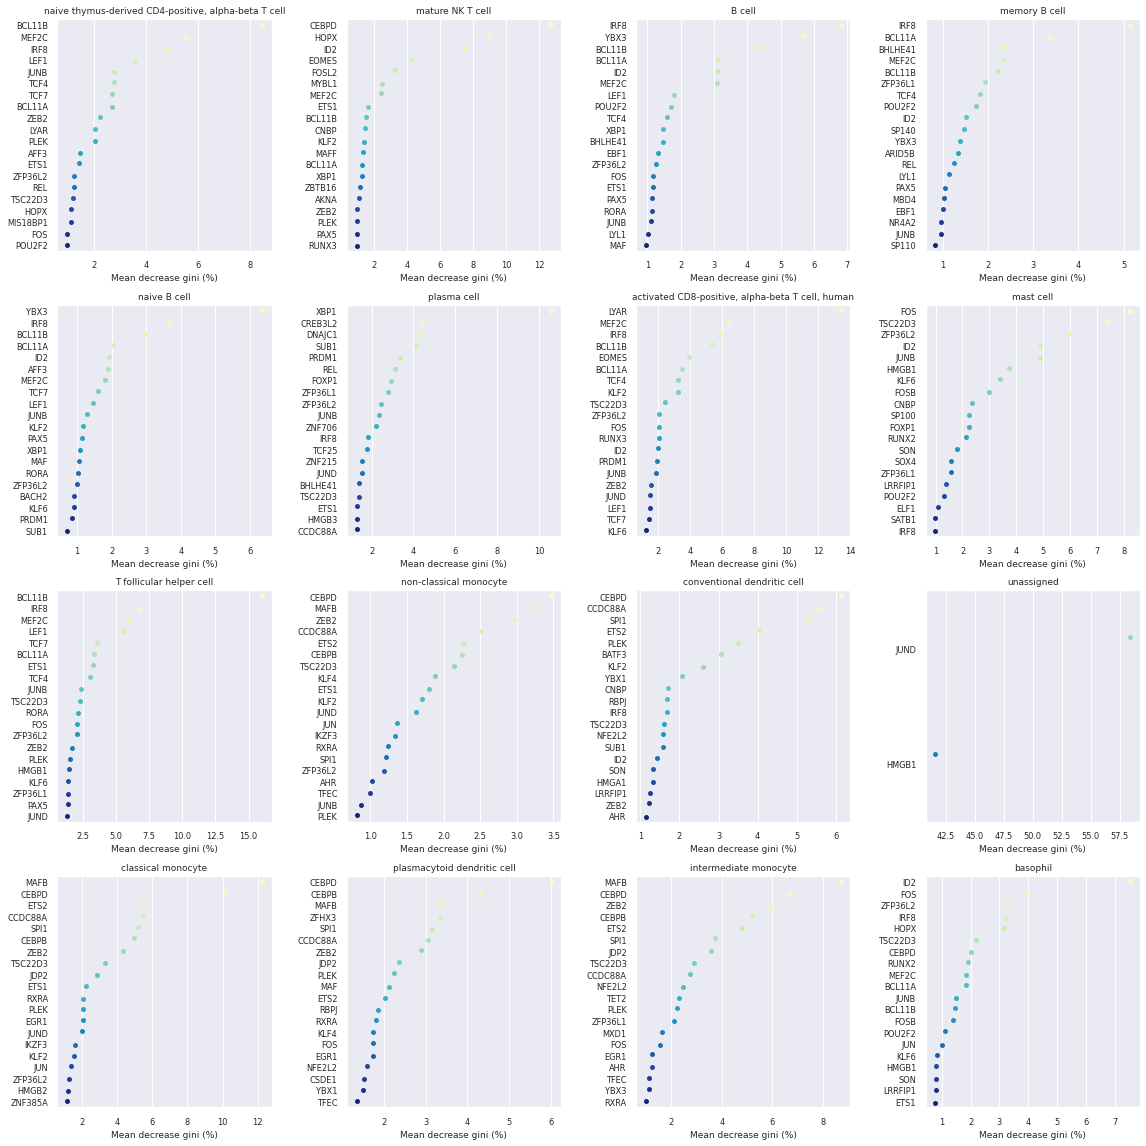

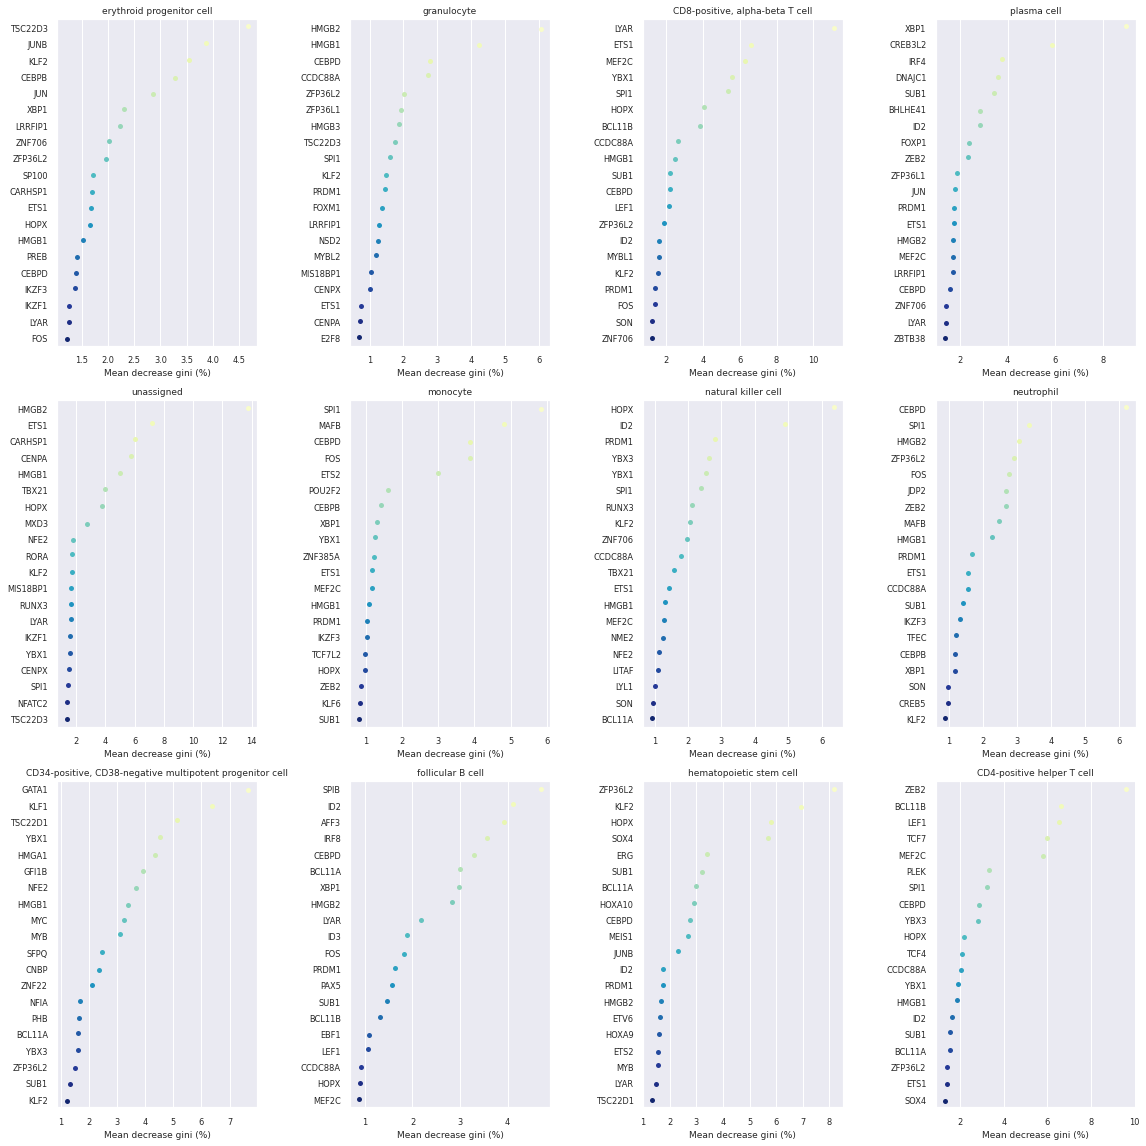

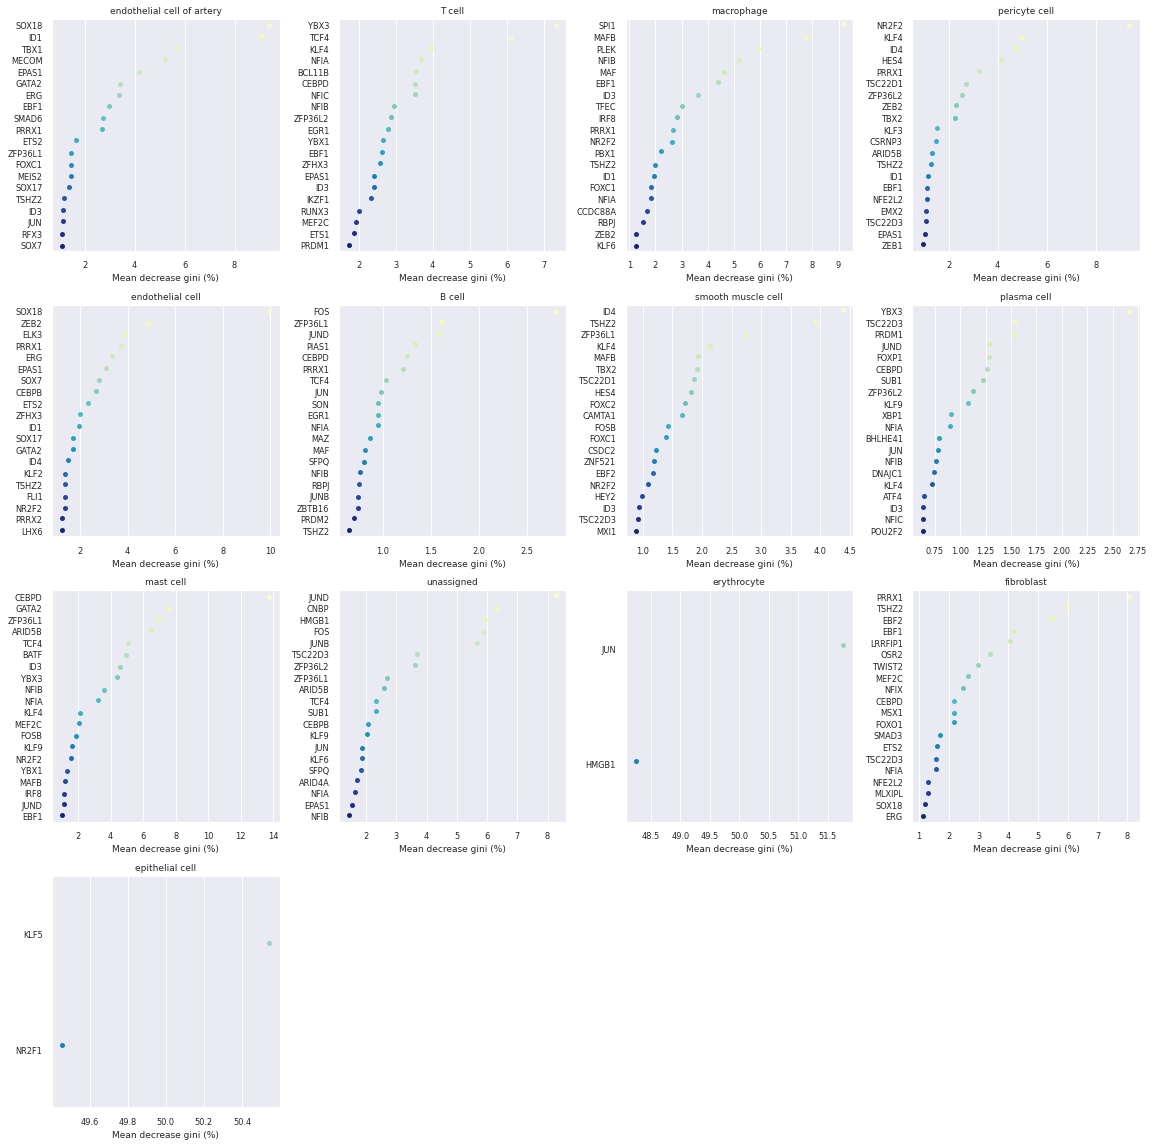

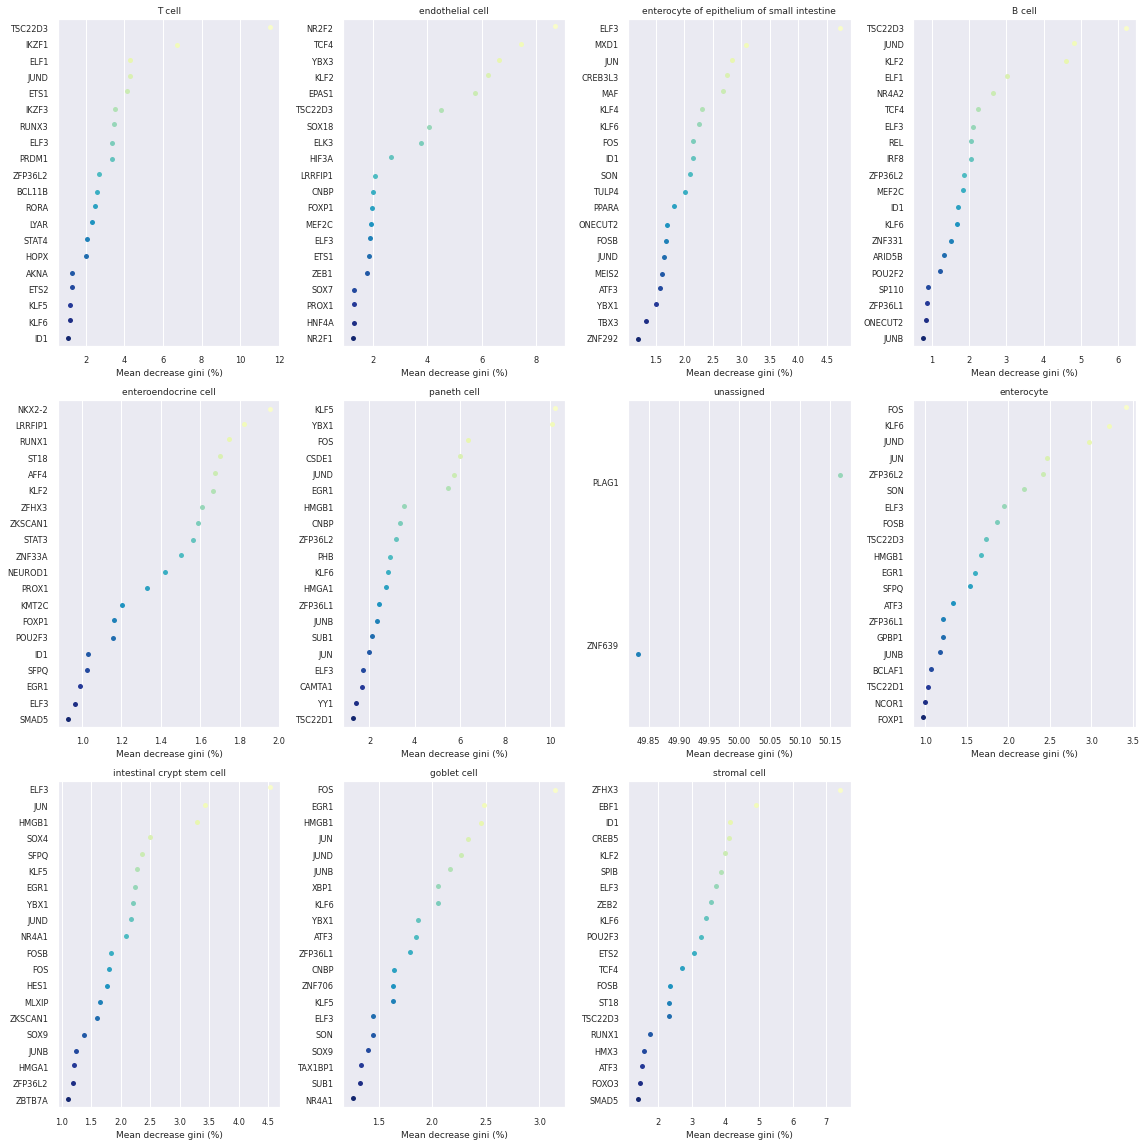

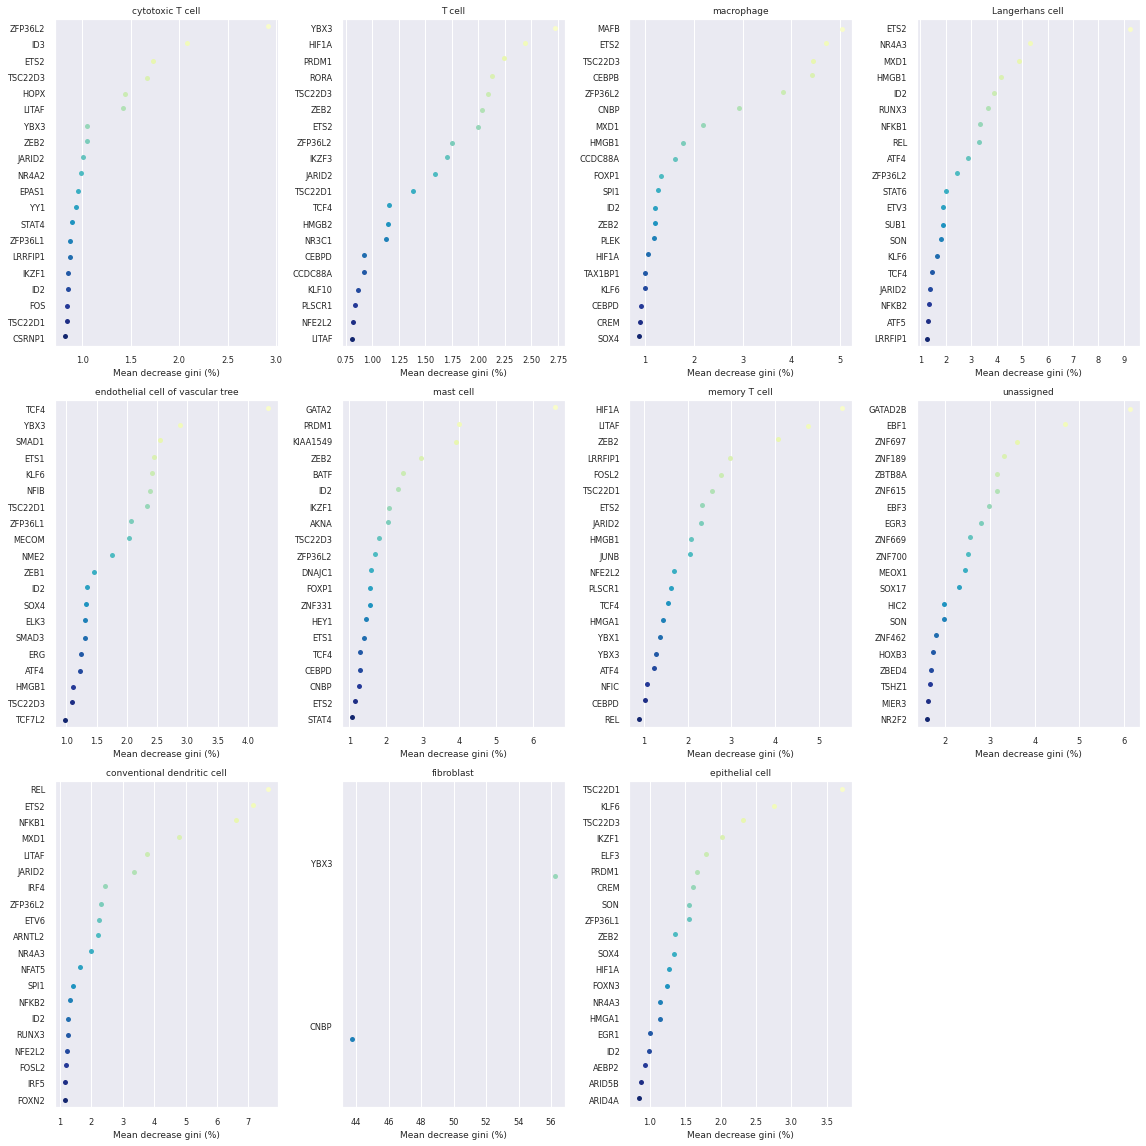

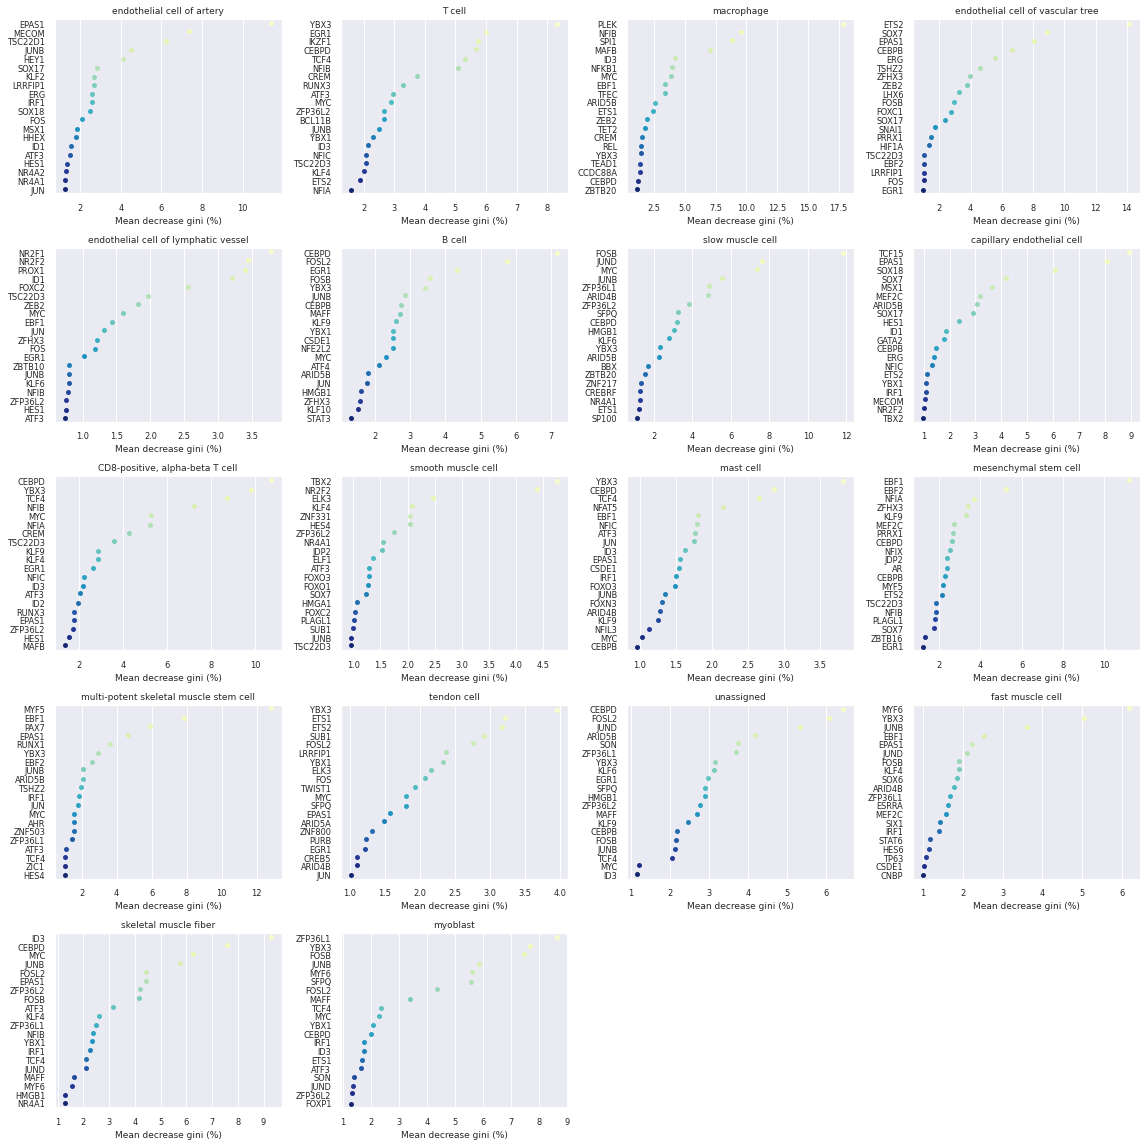

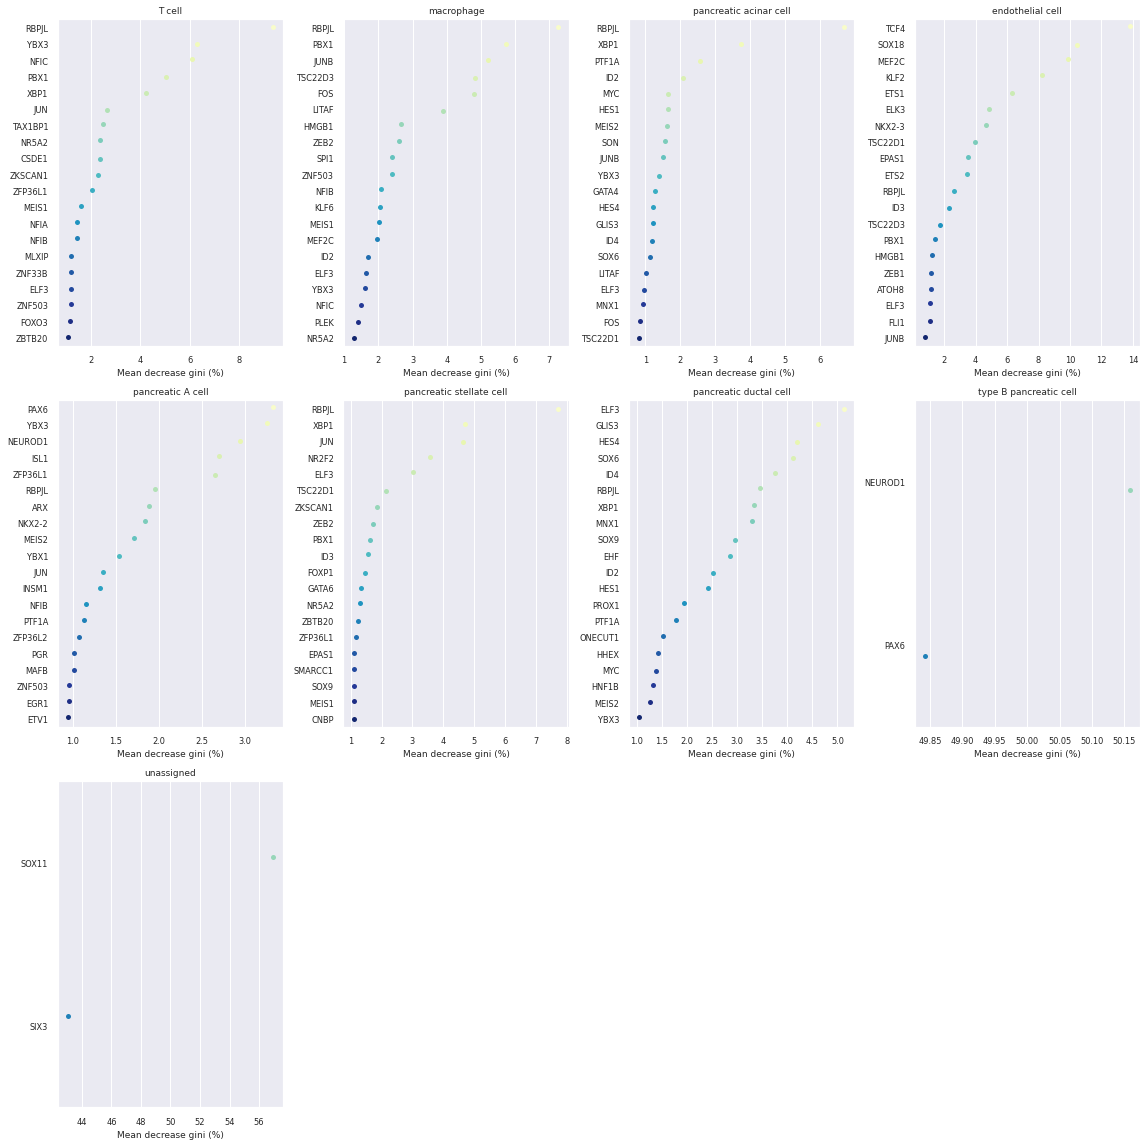

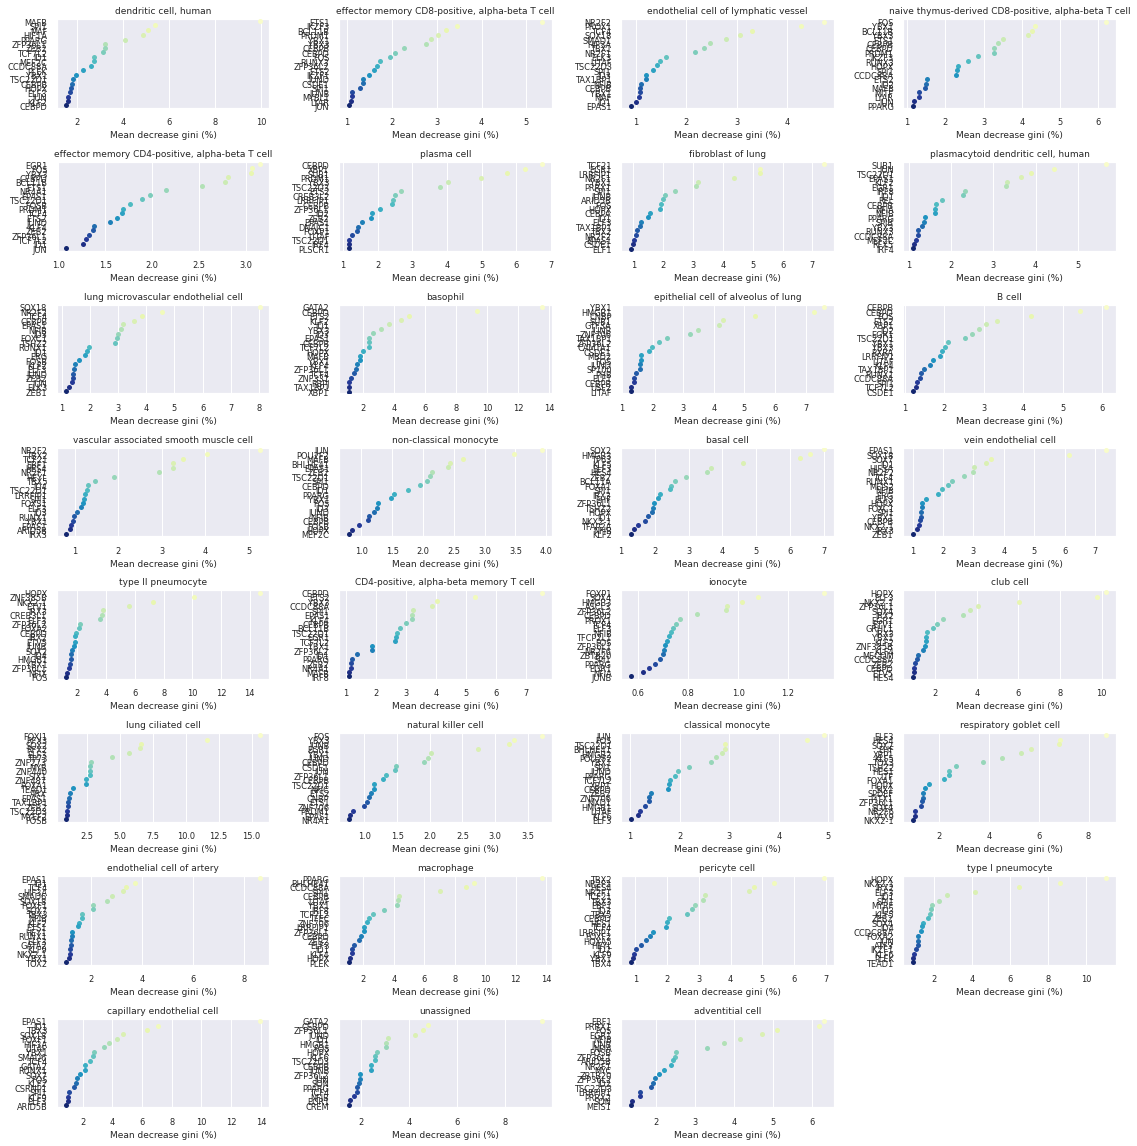

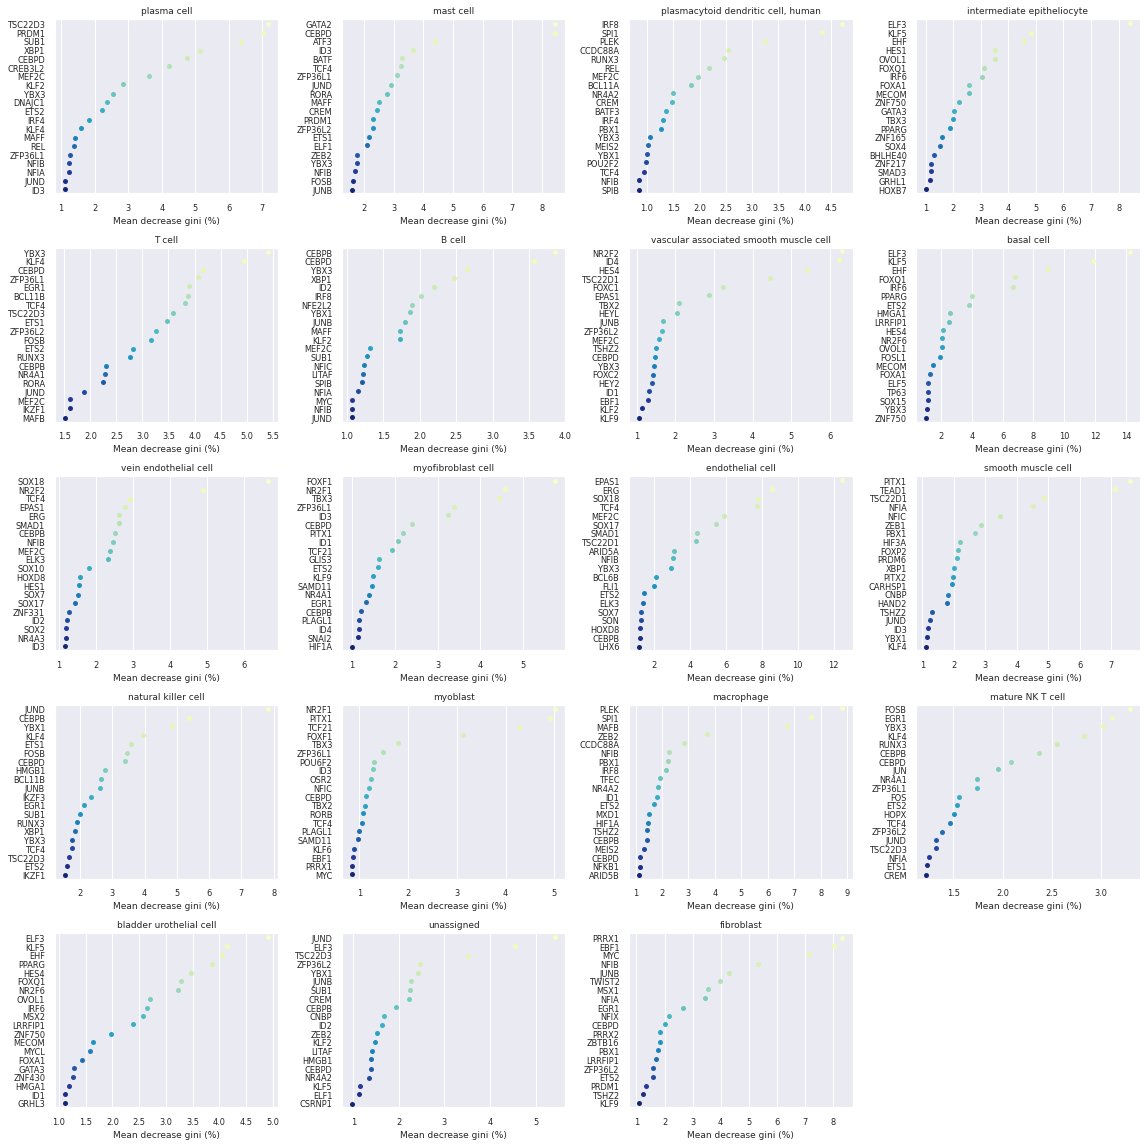

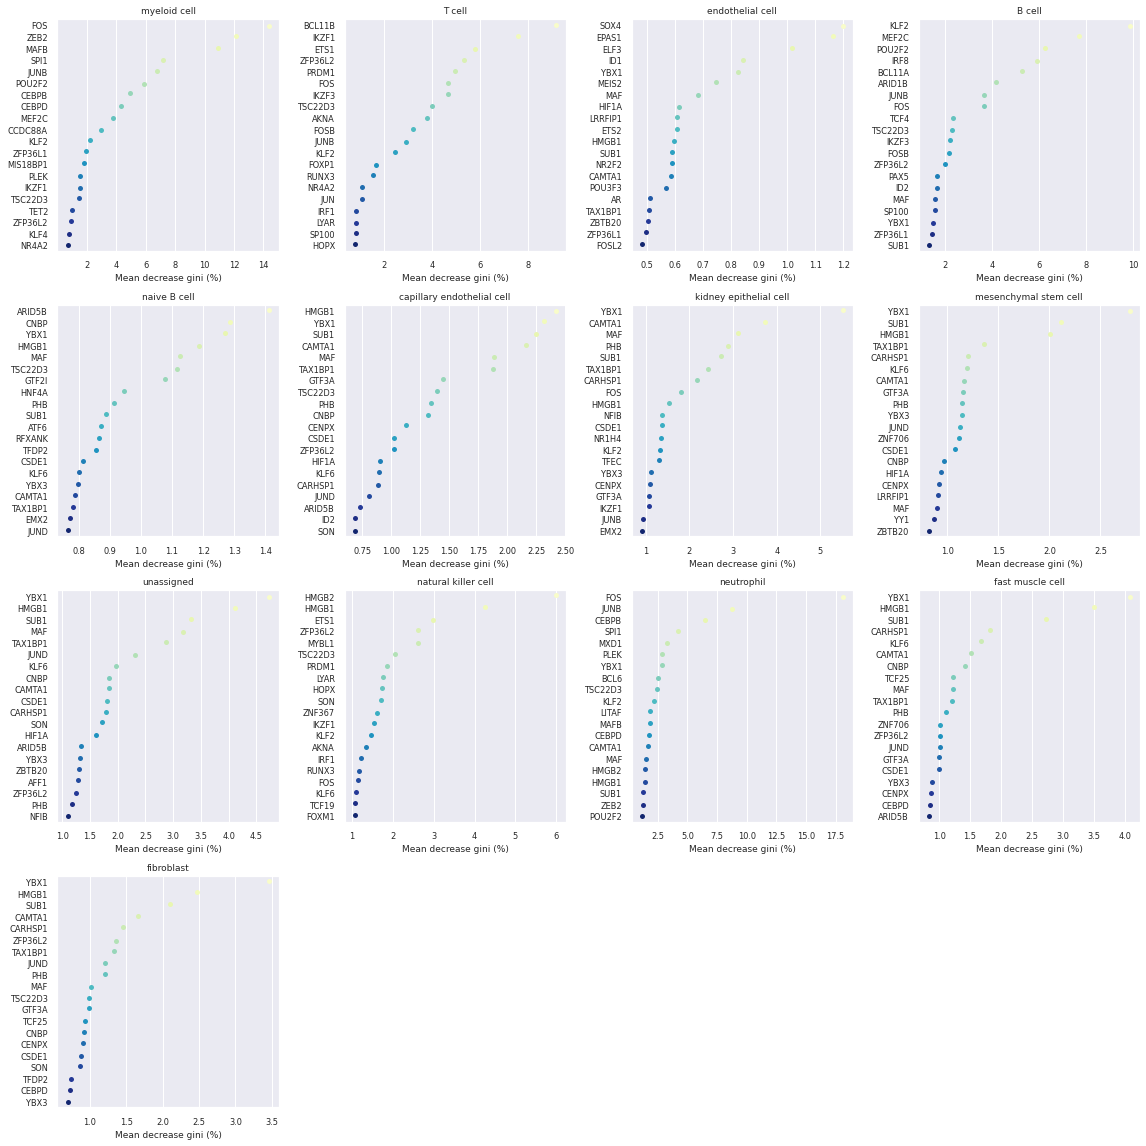

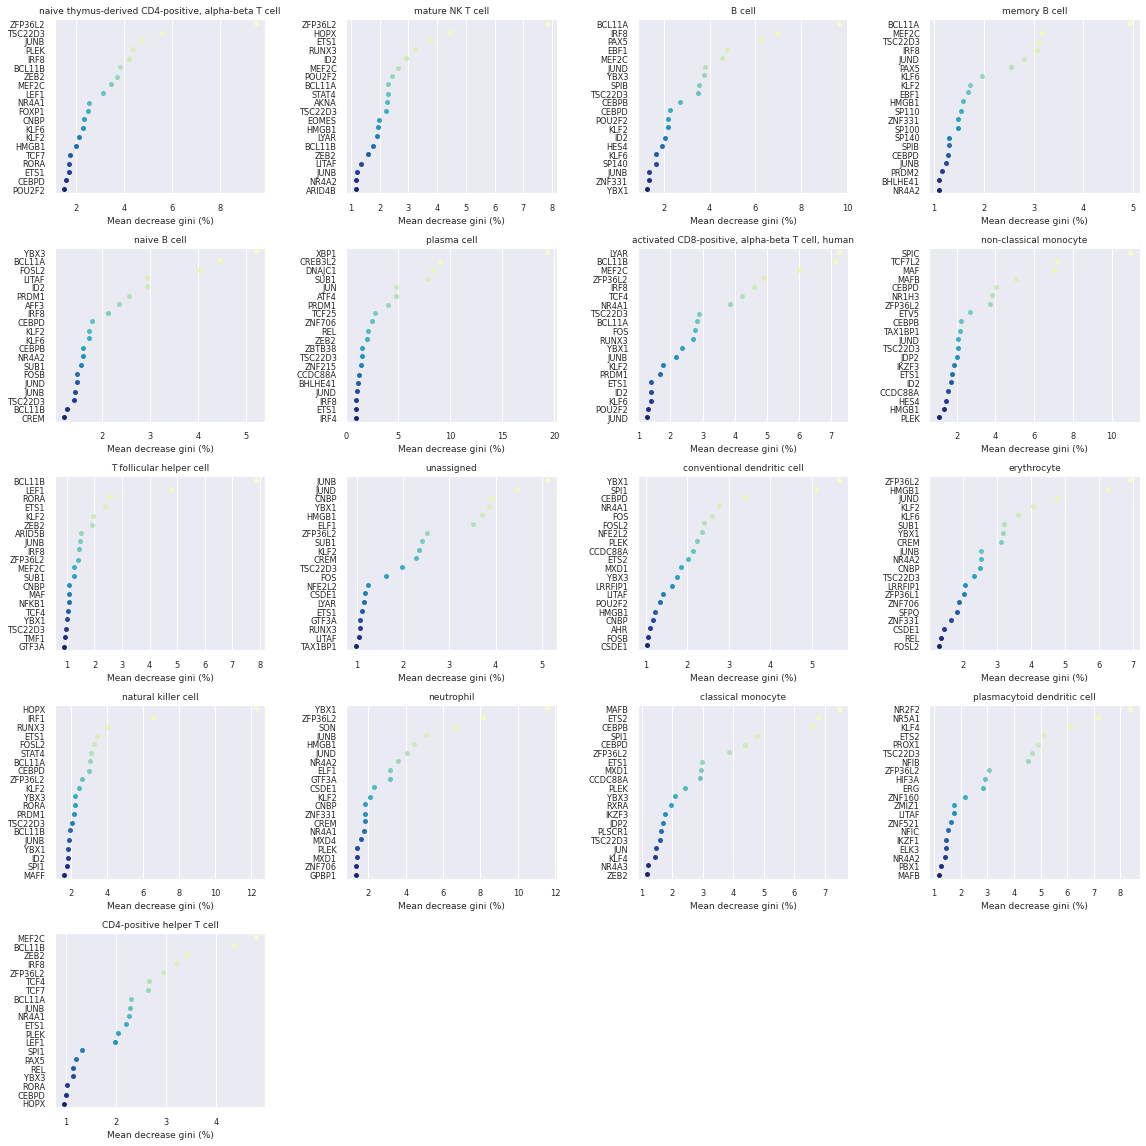

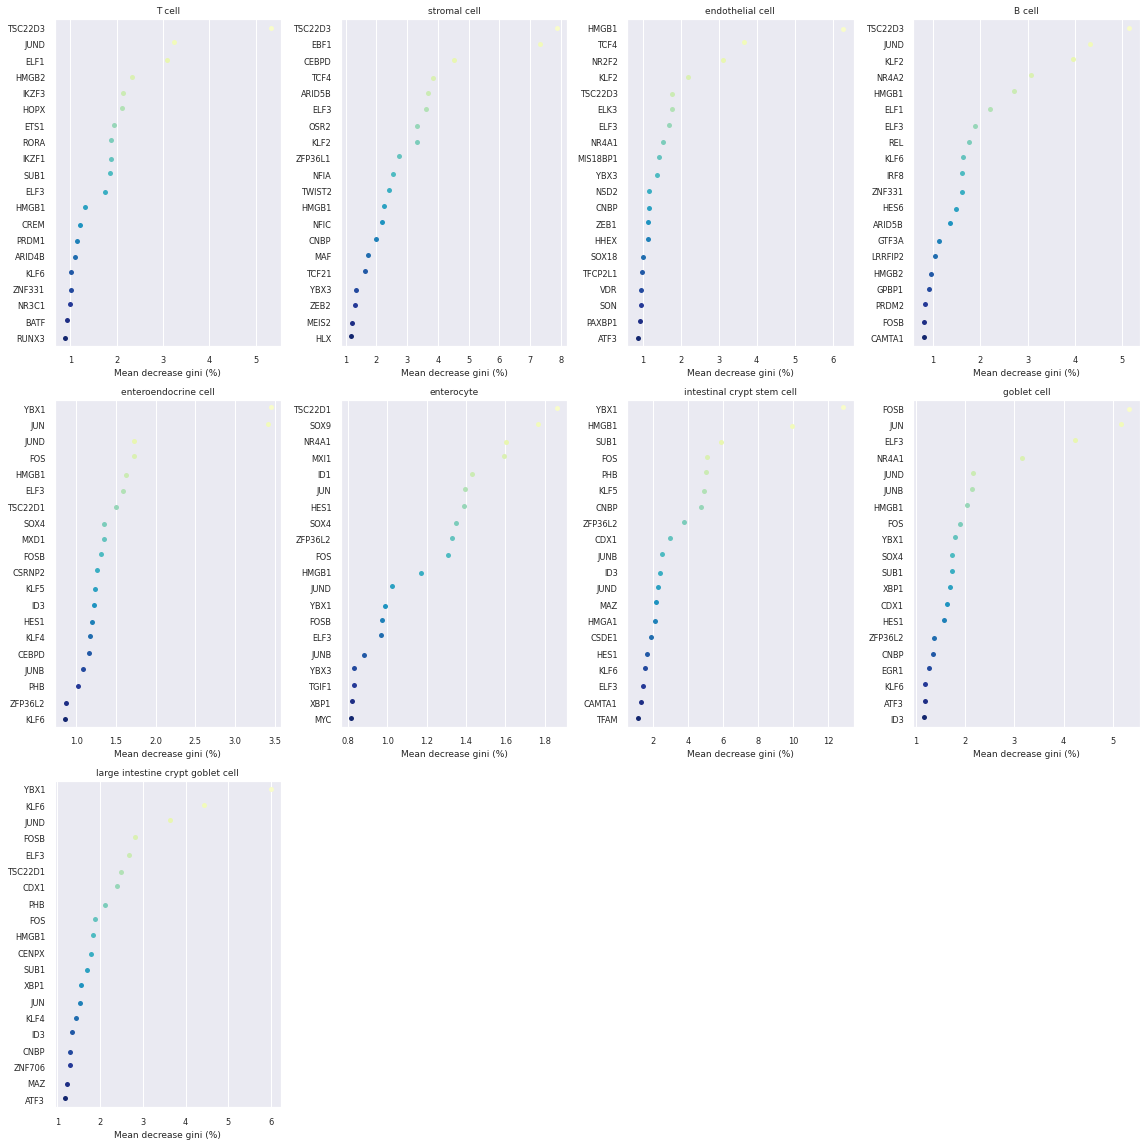

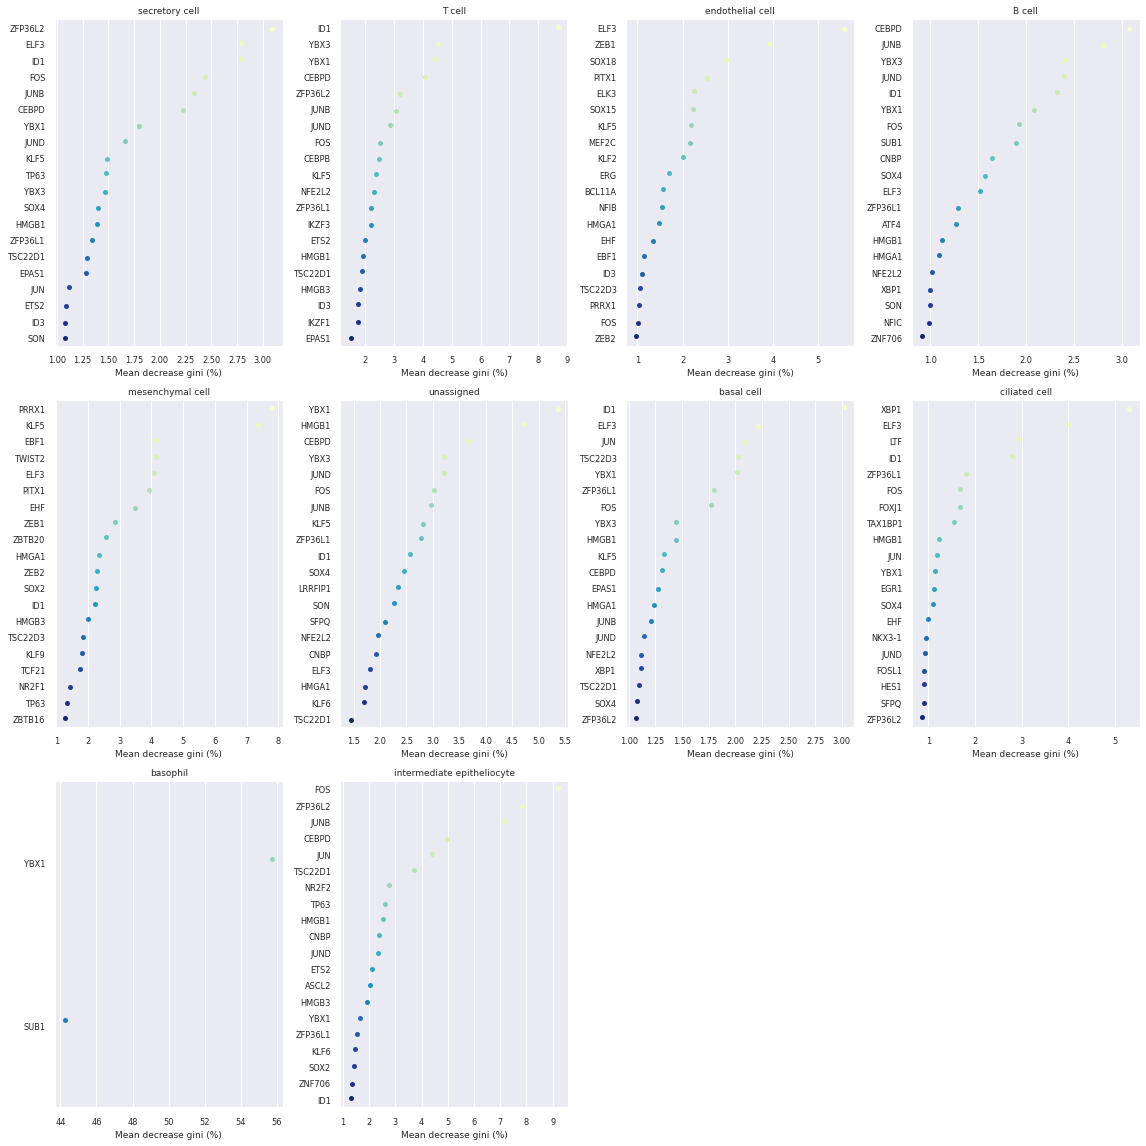

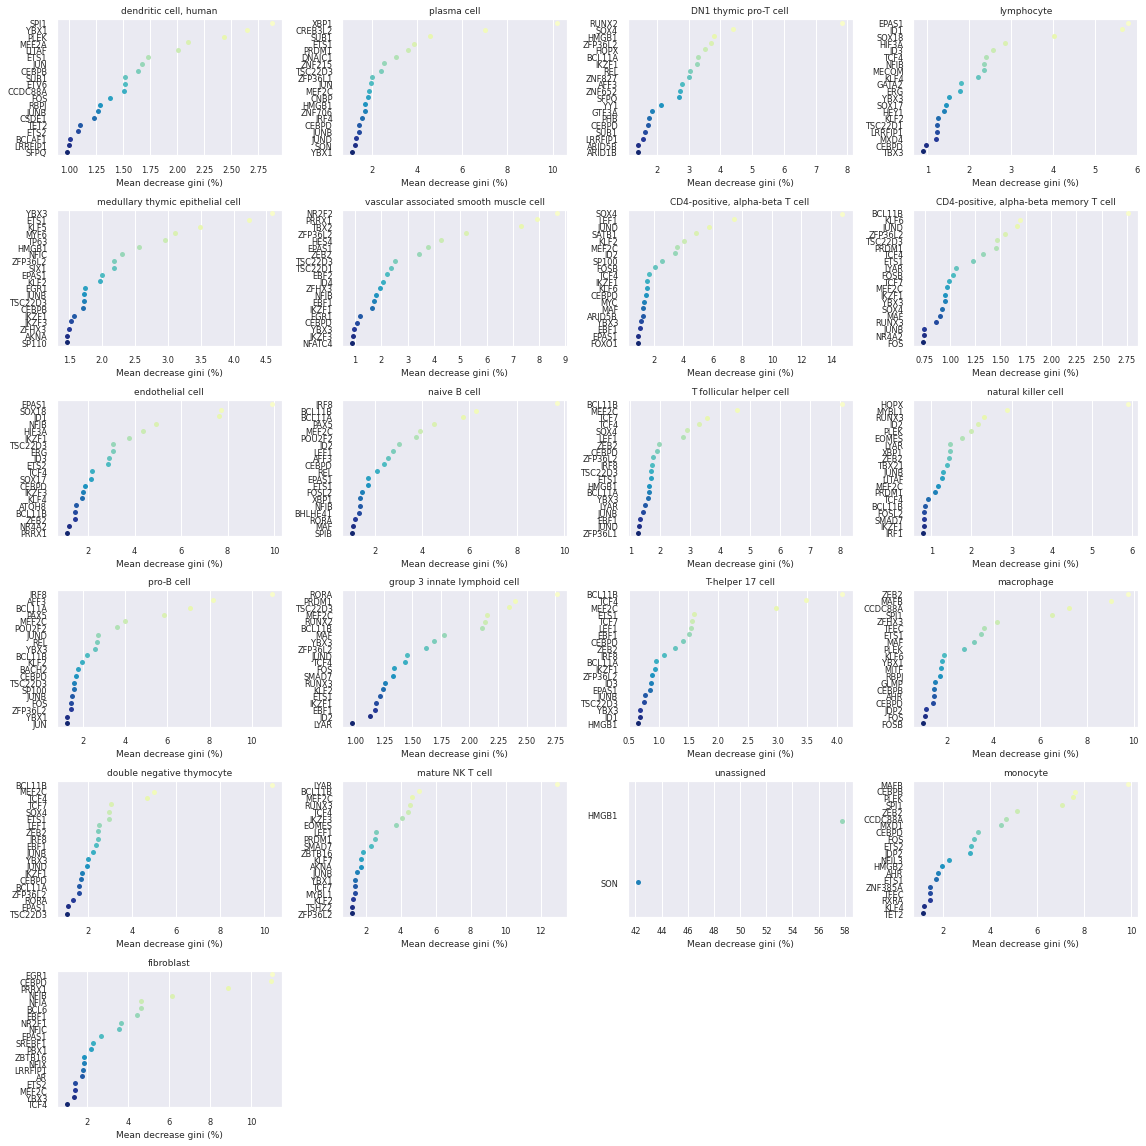

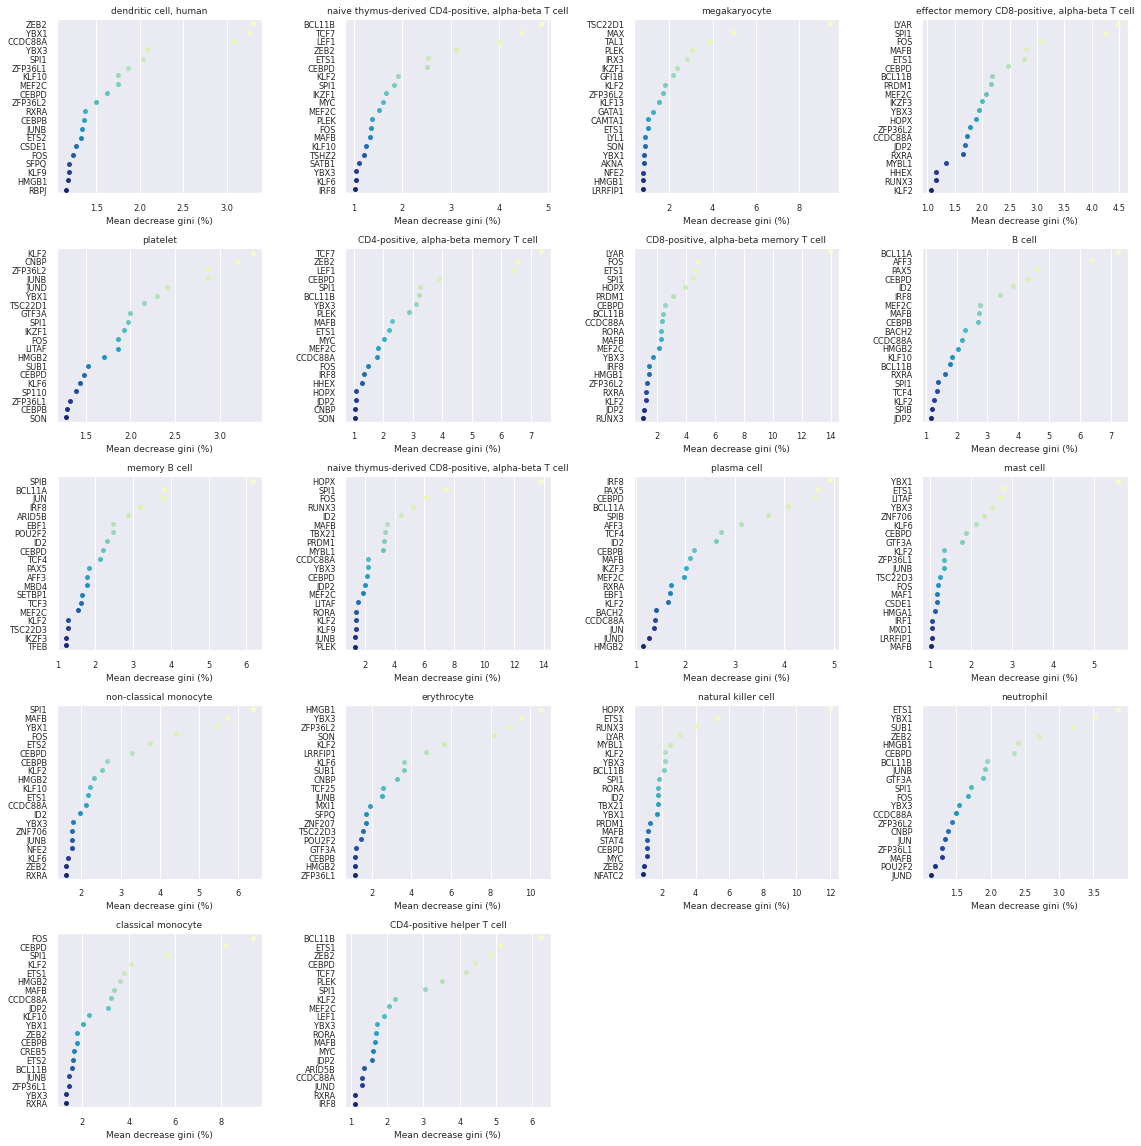

In [214]:
sns.set(font_scale=.75) 

for t in list(tiss_scRFE_res.keys()):
    print(t)
    tiss_df = tiss_scRFE_summary[tiss_scRFE_summary['tissue']==t].reset_index()
    
    l = len(set(tiss_df['cell_type']))
    nrows = np.int(np.ceil(l/4))
    
    fig,ax = plt.subplots(nrows,4, figsize=(16,16));
    
    for c,a in zip(set(tiss_df['cell_type']),ax.flatten()):
        
        df = tiss_df[tiss_df['cell_type']==c]
        sns.catplot(data=df, x = "gini_score",y="marker_gene",ax=a,palette='YlGnBu', height=6, aspect=2)
        a.set_title(c)
        a.set(xlabel="Mean decrease gini (%)", ylabel="");
        plt.close(plt.gcf())
    
    if nrows*4>l:
        empty_ax = nrows*4-l
        for i in range(l,l+empty_ax):
            fig.delaxes(ax.flatten()[i])
        
    plt.tight_layout()
    plt.savefig("scRFE/figures/ts_scRFE_1000_"+t+".pdf")
    plt.savefig("scRFE/figures/ts_scRFE_1000_"+t+".png")
    
    


In [128]:
sum(tiss_scRFE_summary['marker_gene'].isna())

0

In [112]:
tiss_scRFE_res['Vasculature'].columns

Index(['B cell', 'B cell_gini', 'T cell', 'T cell_gini', 'endothelial cell',
       'endothelial cell_gini', 'endothelial cell of artery',
       'endothelial cell of artery_gini', 'epithelial cell',
       'epithelial cell_gini', 'erythrocyte', 'erythrocyte_gini', 'fibroblast',
       'fibroblast_gini', 'macrophage', 'macrophage_gini', 'mast cell',
       'mast cell_gini', 'pericyte cell', 'pericyte cell_gini', 'plasma cell',
       'plasma cell_gini', 'smooth muscle cell', 'smooth muscle cell_gini',
       'unassigned', 'unassigned_gini'],
      dtype='object')

In [122]:
tiss_scRFE#_res['Vasculature']

,B cell,B cell_gini,CD4-positive helper T cell,CD4-positive helper T cell_gini,"CD4-positive, alpha-beta memory T cell","CD4-positive, alpha-beta memory T cell_gini","CD8-positive, alpha-beta memory T cell","CD8-positive, alpha-beta memory T cell_gini",classical monocyte,classical monocyte_gini,...,natural killer cell,natural killer cell_gini,neutrophil,neutrophil_gini,non-classical monocyte,non-classical monocyte_gini,plasma cell,plasma cell_gini,platelet,platelet_gini
0,BCL11A,0.072386,BCL11B,0.062453,TCF7,0.073507,LYAR,0.139417,FOS,0.093511,...,HOPX,0.119861,ETS1,0.038609,SPI1,0.063763,IRF8,0.049212,KLF2,0.033707
1,AFF3,0.063724,ETS1,0.051109,ZEB2,0.065279,FOS,0.048304,CEBPD,0.081884,...,ETS1,0.052658,YBX1,0.035276,MAFB,0.057248,PAX5,0.046808,CNBP,0.031985
2,PAX5,0.046005,ZEB2,0.048546,LEF1,0.063820,ETS1,0.046092,SPI1,0.056670,...,RUNX3,0.040502,SUB1,0.032001,YBX1,0.054377,CEBPD,0.046179,ZFP36L2,0.028719
3,CEBPD,0.043263,CEBPD,0.044076,CEBPD,0.038943,SPI1,0.044650,KLF2,0.040818,...,LYAR,0.030907,ZEB2,0.027035,FOS,0.044091,BCL11A,0.040687,JUNB,0.028680
4,ID2,0.038442,TCF7,0.041734,SPI1,0.032507,HOPX,0.039283,ETS1,0.037996,...,MYBL1,0.024697,HMGB1,0.024020,ETS2,0.037466,SPIB,0.036772,JUND,0.024145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DBX1,0.000000
1652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PAX6,0.000000
1653,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WT1,0.000000
1654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ELF5,0.000000


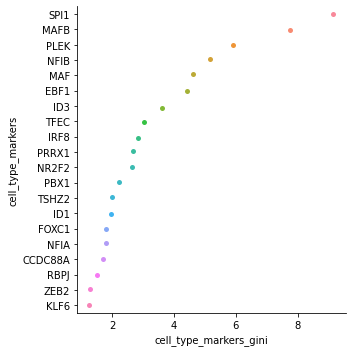

In [113]:
df = tiss_scRFE_res['Vasculature'][['macrophage', 'macrophage_gini']]
df.columns = ['cell_type_markers','cell_type_markers_gini']
df = df.iloc[:20]
df['cell_type_markers_gini'] = df['cell_type_markers_gini']*100 
sns.catplot(data =df, y = 'cell_type_markers', x = 'cell_type_markers_gini')

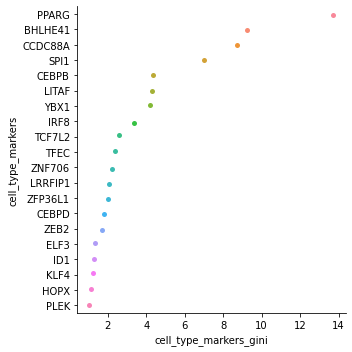

In [114]:
df = tiss_scRFE_res['Lung'][['macrophage', 'macrophage_gini']]
df.columns = ['cell_type_markers','cell_type_markers_gini']
df = df.iloc[:20]
df['cell_type_markers_gini'] = df['cell_type_markers_gini']*100 
sns.catplot(data =df, y = 'cell_type_markers', x = 'cell_type_markers_gini')

In [94]:
tiss_scRFE_res['Muscle']['smooth muscle cell'][:20]

0        TBX2
1       NR2F2
2        ELK3
3        KLF4
4      ZNF331
5        HES4
6     ZFP36L2
7       NR4A1
8        JDP2
9        ELF1
10       ATF3
11      FOXO3
12      FOXO1
13       SOX7
14      HMGA1
15      FOXC2
16     PLAGL1
17       SUB1
18       JUNB
19    TSC22D3
Name: smooth muscle cell, dtype: object

In [87]:
tiss_scRFE_res['Bladder']['vascular associated smooth muscle cell'][:20]

0       NR2F2
1         ID4
2        HES4
3     TSC22D1
4       FOXC1
5       EPAS1
6        TBX2
7        HEYL
8        JUNB
9     ZFP36L2
10      MEF2C
11      TSHZ2
12      CEBPD
13       YBX3
14      FOXC2
15       HEY2
16        ID1
17       EBF1
18       KLF2
19       KLF9
Name: vascular associated smooth muscle cell, dtype: object

In [82]:
tiss_scRFE['vascular associated smooth muscle cell'][:20]

0       NR2F2
1       PRRX1
2        TBX2
3     ZFP36L2
4        HES4
5       EPAS1
6        ZEB2
7     TSC22D3
8     TSC22D1
9        EBF2
10        ID4
11      ZFHX3
12       NFIB
13       EBF1
14      IKZF1
15       EGR1
16      CEBPD
17       YBX3
18      IKZF3
19     NFATC4
Name: vascular associated smooth muscle cell, dtype: object

In [84]:
tiss_scRFE['endothelial cell'][:20]

0       EPAS1
1       SOX18
2         ID1
3        NFIB
4       HIF3A
5       IKZF1
6     TSC22D3
7         ERG
8         ID3
9        ETS2
10       TCF4
11      SOX17
12      CEBPD
13      IKZF3
14       KLF4
15      ATOH8
16     BCL11B
17       ZEB2
18      NR4A2
19      PRRX1
Name: endothelial cell, dtype: object

In [86]:
t

'Blood'